In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
from time import time
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import learning_curve
import sklearn.model_selection
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import (SVC, LinearSVC)
from sklearn import pipeline
from sklearn.kernel_approximation import (RBFSampler,Nystroem)
import pickle
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score,roc_auc_score, accuracy_score

from sklearn import decomposition


In [2]:
def clean_text(text):
    """
    Applies some pre-processing on the given text.

    Steps :
    - Removing HTML tags
    - Removing punctuation
    - Lowering text
    """
    
    # remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # remove the characters [\], ['] and ["]
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)    
    
    # convert text to lowercase
    text = text.strip().lower()
    
    # replace punctuation characters with spaces
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)

    return text

def load_train_test_imdb_data(data_dir):
    """Loads the IMDB train/test datasets from a folder path.
    Input:
    data_dir: path to the "aclImdb" folder.
    
    Returns:
    train/test datasets as pandas dataframes.
    """

    data = {}
    for split in ["train", "test"]:
        data[split] = []
        for sentiment in ["neg", "pos"]:
            score = 1 if sentiment == "pos" else 0

            path = os.path.join(data_dir, split, sentiment)
            file_names = os.listdir(path)
            for f_name in file_names:
                with open(os.path.join(path, f_name), "rb") as f:
                    review = f.read()
                    data[split].append([review, score])

    np.random.shuffle(data["train"])        
    data["train"] = pd.DataFrame(data["train"],
                                 columns=['text', 'sentiment'])

    np.random.shuffle(data["test"])
    data["test"] = pd.DataFrame(data["test"],
                                columns=['text', 'sentiment'])

    return data["train"], data["test"]

In [3]:
def plot_learning_curve(estimator, title, X, y, scoring, ylim=None, cv=None,
                        train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects
    """
    
    plt.figure()
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=1, train_sizes=train_sizes, scoring=scoring,error_score=np.nan)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid("on") 
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [4]:
# Utility function to report best scores
def report(results, scoring,n_top=3):
    if len(scoring)>1:
        for s in range(len(scoring)):
            for i in range(1, n_top + 1):
                candidates = np.flatnonzero(results['rank_test_'+scoring[s]] == i)
                for candidate in candidates:
                    print("Model with rank: {0}".format(i))
                    print("Mean validation {0:}: {1:.3f} (std: {2:.3f})".format(
                          scoring[s],
                          results['mean_test_'+scoring[s]][candidate],
                          results['std_test_'+scoring[s]][candidate]))
                    print("Parameters: {0}".format(results['params'][candidate]))
                    print("")
                    
    else:
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation {0:}: {1:.3f} (std: {2:.3f})".format(
                      scoring[0],
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")

In [ ]:
#Data URL: http://ai.stanford.edu/~amaas/data/sentiment/
train_data, test_data = load_train_test_imdb_data(
    data_dir="aclImdb/")

train_data['text'] = [t.decode("utf-8") for t in train_data['text']]
test_data['text'] = [t.decode("utf-8") for t in test_data['text']]

In [ ]:
train_data_1,train_data_2=train_test_split(train_data, test_size=0.4, stratify=train_data['sentiment'], \
                                             random_state=1)
test_data_1,test_data_2=train_test_split(test_data, test_size=0.1, stratify=test_data['sentiment'], \
                                             random_state=2)

In [ ]:
trainset = train_data_2
testset = test_data_2

trainset.to_csv('trainset_p2.csv')
testset.to_csv('testset_p2.csv')

In [5]:
#Load in data
trainset = pd.read_csv('trainset_p2.csv', encoding = "ISO-8859-1").iloc[:,1:]
testset= pd.read_csv('testset_p2.csv', encoding = "ISO-8859-1").iloc[:,1:]

In [6]:
# Transform each text into a TF-IDF vector 
vectorizer = TfidfVectorizer(stop_words="english",
                             preprocessor=clean_text,
                             ngram_range=(1, 2))
vectorizer.fit(pd.concat([trainset['text'],testset['text']]))

training_features = vectorizer.transform(trainset["text"])    
test_features = vectorizer.transform(testset["text"])

In [7]:
#knn
n_iter_search = 3

parameters = {'weights':['uniform', 'distance'], 'algorithm': ['auto', 'brute'], 'metric': ['cosine','l2']}

clf_knn3 = RandomizedSearchCV(neighbors.KNeighborsClassifier(n_neighbors=3), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit=True)

clf_knn6 = RandomizedSearchCV(neighbors.KNeighborsClassifier(n_neighbors=6), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit=True)

In [59]:
#knn3
start = time()
clf_knn3.fit(training_features,trainset["sentiment"])
print("clf_knn3 took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_knn3.cv_results_,scoring=['accuracy'])

clf_knn3 took 47.77 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.751 (std: 0.011)
Parameters: {'metric': 'l2', 'weights': 'distance', 'algorithm': 'brute'}

Model with rank: 2
Mean validation accuracy: 0.750 (std: 0.011)
Parameters: {'metric': 'cosine', 'weights': 'uniform', 'algorithm': 'auto'}

Model with rank: 2
Mean validation accuracy: 0.750 (std: 0.011)
Parameters: {'metric': 'cosine', 'weights': 'uniform', 'algorithm': 'brute'}



KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='l2',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='distance')


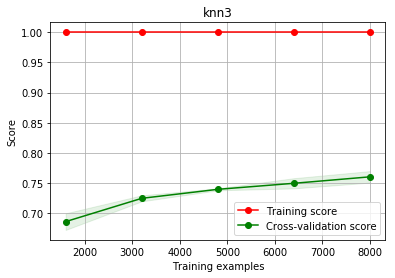

In [60]:
clf_knn3_optim = clf_knn3.best_estimator_
print(clf_knn3_optim)
%matplotlib inline

plot_learning_curve(clf_knn3_optim, "knn3",
                    training_features,trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,6))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_knn3_optim.sav'
pickle.dump(clf_knn3_optim, open(filename, 'wb'))

In [9]:
#create a performacne dataframe and record the performance on both trainset and testset
clf_performance = pd.DataFrame(columns=['classifier','trainset_accuracy','testset_accuracy'])

In [10]:
#clf_knn3_optim = pickle.load(open(r'.\Problem_2_Model\clf_knn3_optim.sav','rb'))

start = time()
clf_knn3_optim.fit(training_features, trainset["sentiment"])
print('The training time of mlp is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_knn3_optim.predict(training_features)

y_pred_test = clf_knn3_optim.predict(test_features)

knn3_perf={'classifier':'knn3',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[0]=knn3_perf

The training time of mlp is 0.026s


In [65]:
#knn6
start = time()
clf_knn6.fit(training_features,trainset["sentiment"])
print("clf_knn6 took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_knn6.cv_results_,scoring=['accuracy'])

clf_knn6 took 56.91 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.770 (std: 0.006)
Parameters: {'metric': 'l2', 'weights': 'distance', 'algorithm': 'brute'}

Model with rank: 2
Mean validation accuracy: 0.758 (std: 0.004)
Parameters: {'metric': 'l2', 'weights': 'uniform', 'algorithm': 'auto'}

Model with rank: 2
Mean validation accuracy: 0.758 (std: 0.004)
Parameters: {'metric': 'l2', 'weights': 'uniform', 'algorithm': 'brute'}



KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='l2',
           metric_params=None, n_jobs=None, n_neighbors=6, p=2,
           weights='distance')


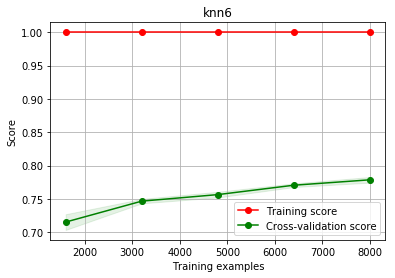

In [66]:
clf_knn6_optim = clf_knn6.best_estimator_
print(clf_knn6_optim)
%matplotlib inline

plot_learning_curve(clf_knn6_optim, "knn6",
                    training_features,trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,6))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_knn6_optim.sav'
pickle.dump(clf_knn6_optim, open(filename, 'wb'))

In [12]:
#clf_knn6_optim = pickle.load(open(r'.\Problem_2_Model\clf_knn6_optim.sav','rb'))

start = time()
clf_knn6_optim.fit(training_features, trainset["sentiment"])
print('The training time of knn6 is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_knn6_optim.predict(training_features)

y_pred_test = clf_knn6_optim.predict(test_features)

knn6_perf={'classifier':'knn6',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=knn6_perf

The training time of knn6 is 0.028s


In [69]:
#decision tree
parameters = {'splitter':['best', 'random'], 'max_depth': [None, 5, 7, 9], 
              'min_samples_split': np.linspace(2,10,num=5).astype(int),
              'max_features': ['auto','log2',None]}

clf_dt = RandomizedSearchCV(DecisionTreeClassifier(criterion='entropy'), param_distributions=parameters,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit='accuracy')

In [70]:
start = time()
clf_dt.fit(training_features, trainset["sentiment"])
print("Decision tree took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_dt.cv_results_,scoring=['accuracy'])

Decision tree took 9.01 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.576 (std: 0.010)
Parameters: {'max_features': 'log2', 'splitter': 'best', 'min_samples_split': 10, 'max_depth': None}

Model with rank: 2
Mean validation accuracy: 0.525 (std: 0.002)
Parameters: {'max_features': 'auto', 'splitter': 'best', 'min_samples_split': 10, 'max_depth': 9}

Model with rank: 3
Mean validation accuracy: 0.501 (std: 0.001)
Parameters: {'max_features': 'log2', 'splitter': 'random', 'min_samples_split': 4, 'max_depth': 7}



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


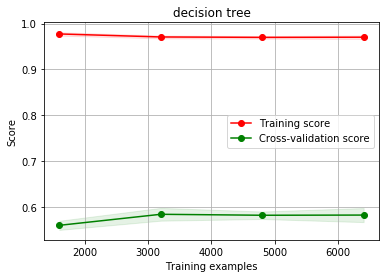

In [71]:
clf_dt_optim = clf_dt.best_estimator_
print(clf_dt_optim)

%matplotlib inline

plot_learning_curve(clf_dt_optim , "decision tree",
                    training_features, trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,5))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_dt_optim.sav'
pickle.dump(clf_dt_optim, open(filename, 'wb'))

In [13]:
clf_dt_optim = pickle.load(open(r'.\Problem_2_Model\clf_dt_optim.sav', 'rb'))

start = time()
clf_dt_optim.fit(training_features, trainset["sentiment"])
print('The training time of decision tree is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_dt_optim.predict(training_features)

y_pred_test = clf_dt_optim.predict(test_features)

dt_perf={'classifier':'dt',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=dt_perf

The training time of decision tree is 2.108s


In [17]:
#svm
n_iter_search = 3

parameters_lin = {'loss':['hinge','squared_hinge'], 'C':list(10. ** np.arange(-4, 6))}
parameters_rbf = {'C':list(10. ** np.arange(-4, 6)), 'shrinking': [True, False], 'gamma':np.linspace(0.000001,0.0001,num=10)}



clf_svclin = RandomizedSearchCV(LinearSVC(max_iter=500000), param_distributions=parameters_lin,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit='accuracy')

clf_svcrbf = RandomizedSearchCV(SVC(kernel='rbf',max_iter=500000), param_distributions=parameters_rbf,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit='accuracy')

In [81]:
#linear kernel
start = time()
clf_svclin.fit(training_features, trainset["sentiment"])
print("Linear kernel svc took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_svclin.cv_results_,scoring=['accuracy'])

Linear kernel svc took 11.09 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.878 (std: 0.004)
Parameters: {'loss': 'squared_hinge', 'C': 10.0}

Model with rank: 2
Mean validation accuracy: 0.852 (std: 0.005)
Parameters: {'loss': 'squared_hinge', 'C': 0.1}

Model with rank: 3
Mean validation accuracy: 0.792 (std: 0.003)
Parameters: {'loss': 'hinge', 'C': 0.0001}



LinearSVC(C=10.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=5000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


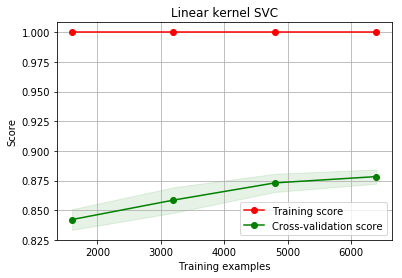

In [82]:
clf_svclin_optim = clf_svclin.best_estimator_
print(clf_svclin_optim)

%matplotlib inline

plot_learning_curve(clf_svclin_optim , "Linear kernel SVC",
                    training_features, trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,5))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_svclin_optim.sav'
pickle.dump(clf_svclin_optim, open(filename, 'wb'))

In [14]:
clf_svclin_optim = pickle.load(open(r'.\Problem_2_Model\clf_svclin_optim.sav', 'rb'))

start = time()
clf_svclin_optim.fit(training_features, trainset["sentiment"])
print('The training time of SVC Linear kernel is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_svclin_optim.predict(training_features)

y_pred_test = clf_svclin_optim.predict(test_features)

svclin_perf={'classifier':'svclin',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=svclin_perf

The training time of SVC Linear kernel is 3.405s


In [18]:
#rbf kernel
start = time()
clf_svcrbf.fit(training_features, trainset["sentiment"])
print("RBF kernel svc took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_svcrbf.cv_results_,scoring=['accuracy'])

RBF kernel svc took 1752.57 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.785 (std: 0.017)
Parameters: {'C': 1000.0, 'shrinking': False, 'gamma': 1e-06}

Model with rank: 2
Mean validation accuracy: 0.631 (std: 0.023)
Parameters: {'C': 0.0001, 'shrinking': True, 'gamma': 5.6000000000000006e-05}

Model with rank: 3
Mean validation accuracy: 0.631 (std: 0.023)
Parameters: {'C': 0.01, 'shrinking': True, 'gamma': 7.800000000000001e-05}



SVC(C=1000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-06, kernel='rbf',
  max_iter=500000, probability=False, random_state=None, shrinking=False,
  tol=0.001, verbose=False)


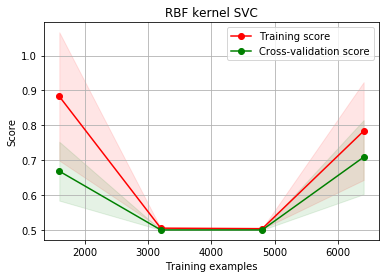

In [19]:
clf_svcrbf_optim = clf_svcrbf.best_estimator_
print(clf_svcrbf_optim)

%matplotlib inline

plot_learning_curve(clf_svcrbf_optim , "RBF kernel SVC",
                    training_features, trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,5))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_svcrbf_optim.sav'
pickle.dump(clf_svcrbf_optim, open(filename, 'wb'))

In [20]:
clf_svcrbf_optim = pickle.load(open(r'.\Problem_2_Model\clf_svcrbf_optim.sav', 'rb'))

start = time()
clf_svcrbf_optim.fit(training_features, trainset["sentiment"])
print('The training time of SVC RBF kernel is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_svcrbf_optim.predict(training_features)

y_pred_test = clf_svcrbf_optim.predict(test_features)


svcrbf_perf={'classifier':'svcrbf',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=svcrbf_perf

The training time of SVC RBF kernel is 168.296s


In [8]:
#boosting
parameters_Ada = {'n_estimators':np.linspace(25,250,num=10).astype(int), 
                  'learning_rate': np.linspace(0.1,1,num=19), 'algorithm':['SAMME','SAMME.R']}

parameters_gradient = {'loss':['deviance','exponential'], 'learning_rate': np.linspace(0.1,1,num=19),
                       'n_estimators':np.linspace(25,250,num=10).astype(int),'subsample':np.linspace(0.1,1,num=10),
                       'criterion':['friedman_mse','mse','mae'],'min_samples_split': np.linspace(2,10,num=5).astype(int),
                       'max_depth': [None, 5, 7, 9], 'max_features': ['auto','log2',None]}



clf_adaboosting = RandomizedSearchCV(AdaBoostClassifier(), param_distributions=parameters_Ada,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit='accuracy')

clf_gradientboosting = \
                    RandomizedSearchCV(GradientBoostingClassifier(), param_distributions=parameters_gradient,
                                   n_iter=n_iter_search, scoring='accuracy', cv=3,refit='accuracy')

In [92]:
#Adaboost
start = time()
clf_adaboosting.fit(training_features, trainset["sentiment"])
print("Adaboosting classifier took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_adaboosting.cv_results_,scoring=['accuracy'])

Adaboosting classifier took 10097.05 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.817 (std: 0.007)
Parameters: {'learning_rate': 0.45000000000000007, 'n_estimators': 150, 'algorithm': 'SAMME.R'}

Model with rank: 2
Mean validation accuracy: 0.765 (std: 0.005)
Parameters: {'learning_rate': 0.65, 'n_estimators': 225, 'algorithm': 'SAMME'}

Model with rank: 3
Mean validation accuracy: 0.758 (std: 0.005)
Parameters: {'learning_rate': 0.65, 'n_estimators': 175, 'algorithm': 'SAMME'}



AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.45000000000000007, n_estimators=150,
          random_state=None)


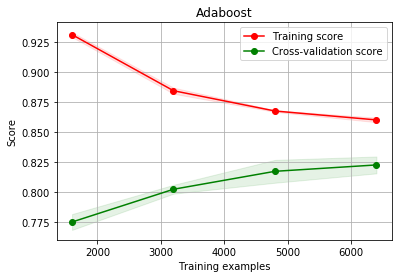

In [93]:
#clf_adaboosting_optim = pickle.load(open(r'.\Problem_2_Model\clf_adaboosting_optim.sav', 'rb'))
clf_adaboosting_optim = clf_adaboosting.best_estimator_
print(clf_adaboosting_optim)

%matplotlib inline

plot_learning_curve(clf_adaboosting_optim , "Adaboost",
                    training_features, trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,5))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_adaboosting_optim.sav'
pickle.dump(clf_adaboosting_optim, open(filename, 'wb'))

In [ ]:
clf_adaboosting_optim = pickle.load(open(r'.\Problem_2_Model\clf_adaboosting_optim.sav', 'rb'))

start = time()
clf_adaboosting_optim.fit(training_features, trainset["sentiment"])
print('The training time of Ada boost is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_adaboosting_optim.predict(training_features)

y_pred_test = clf_adaboosting_optim.predict(test_features)


adaboost_perf={'classifier':'adaboost',
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=adaboost_perf

The training time of Ada boost is 1537.712s


In [ ]:
#graident boost
start = time()
clf_gradientboosting.fit(training_features, trainset["sentiment"])
print("Gradient boost classifier took %.2f seconds for %d candidates parameter settings." % ((time() - start), n_iter_search))
report(clf_gradientboosting.cv_results_,scoring=['accuracy'])

Gradient boost classifier took 27062.80 seconds for 3 candidates parameter settings.
Model with rank: 1
Mean validation accuracy: 0.798 (std: 0.005)
Parameters: {'min_samples_split': 8, 'learning_rate': 0.4, 'n_estimators': 150, 'subsample': 0.6, 'criterion': 'friedman_mse', 'max_features': 'auto', 'max_depth': None, 'loss': 'deviance'}

Model with rank: 2
Mean validation accuracy: 0.773 (std: 0.004)
Parameters: {'min_samples_split': 8, 'learning_rate': 0.8, 'n_estimators': 250, 'subsample': 0.30000000000000004, 'criterion': 'mse', 'max_features': None, 'max_depth': None, 'loss': 'exponential'}

Model with rank: 3
Mean validation accuracy: 0.752 (std: 0.010)
Parameters: {'min_samples_split': 8, 'learning_rate': 0.35, 'n_estimators': 50, 'subsample': 0.1, 'criterion': 'friedman_mse', 'max_features': 'auto', 'max_depth': 5, 'loss': 'exponential'}



In [ ]:
#clf_gradientboosting_optim = pickle.load(open(r'.\Problem_2_Model\clf_gradientboosting_optim.sav','rb'))
clf_gradientboosting_optim = clf_gradientboosting.best_estimator_

print(clf_gradientboosting_optim)

%matplotlib inline

plot_learning_curve(clf_gradientboosting_optim , "gradientboosting",
                    training_features, trainset["sentiment"], scoring='accuracy',
                    train_sizes=np.array(range(1,5))/5)

# save the model to disk
filename = r'.\Problem_2_Model\clf_gradientboosting_optim.sav'
pickle.dump(clf_gradientboosting_optim, open(filename, 'wb'))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.4, loss='deviance', max_depth=None,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              n_iter_no_change=2, presort='auto', random_state=None,
              subsample=0.6, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


In [ ]:
#clf_gradientboosting_optim = pickle.load(open('clf_gradientboosting_optim.sav', 'rb'))

start = time()
clf_gradientboosting_optim.fit(training_features, trainset["sentiment"])
print('The training time of gradient boosting is %.3fs'%(round(time()-start,3)))

y_pred_train = clf_gradientboosting_optim.predict(training_features)

y_pred_test = clf_gradientboosting_optim.predict(test_features)


gradientboosting_perf={'classifier':'gradientboosting,
           'trainset_accuracy':accuracy_score(trainset["sentiment"],y_pred_train),
           'testset_accuracy':accuracy_score(testset["sentiment"],y_pred_test)
          }

clf_performance.loc[(clf_performance.index.max()+1)]=gradientboosting_perf

In [ ]:
clf_performance.to_csv('model_performance_p2.csv')